In [1]:
import numpy as np
import torch as ch
import matplotlib.pyplot as plt
from tqdm import tqdm
from aicsimageio import AICSImage
from confocalQuant.segmentation import (
    show_im,
    load_2D,
    threshold_im,
    update_image,
    load_3D,
    apply_thresh_all_Z,
    do_inference,
    get_anisotropy,
    sigmoid,
    toggle_segmentation,
    extract_channels,
    show_maxproj_with_outlines,
    hide_masks
)
from confocalQuant.quantification import get_im_stats

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


### Thresholding


In [70]:
channels = [0,1,2] # channel order SREBPorTOMM20/NeuN/DAPI
path = './data/10252023_SREBP2_matchedcohort/10101327con_1.czi'
im, bounds = show_im(path, N_channels = channels)

im

In [4]:
bounds

{0: (51.56, 99.52), 1: (50.32, 99.52), 2: (1, 99)}

### Apply Thresholds & Do inference

In [63]:
# load image with channels from above
img = AICSImage(path)
out = load_3D(img, channels)

# load the model
model = ch.load('./models/cyto2')

# thresholding
mat = apply_thresh_all_Z(out, bounds)

100%|██████████| 26/26 [00:03<00:00,  8.38it/s]


In [64]:
anisotropy = get_anisotropy(img)
print(anisotropy)

2.4088670663621183


In [66]:
# do inference
masks, flows = do_inference(mat, do_3D=True, model=model, anisotropy=anisotropy, diameter=20, channels=[2, 0], channel_axis=3, z_axis=0, min_size=1000)

In [68]:
img.physical_pixel_sizes

PhysicalPixelSizes(Z=1.0, Y=0.41513291204989755, X=0.41513291204989755)

In [69]:
np.save('./temp/masks_temp.npy', masks)
np.save('./temp/probs_temp.npy', sigmoid(flows[2]))
np.save('./temp/mat_temp.npy', mat)

### Toggle through segmentation

In [73]:
# show without filtering
masks = np.load('./temp/masks_temp.npy')
mat = np.load('./temp/mat_temp.npy')
probs = np.load('./temp/probs_temp.npy')

channels = [0,1,2]

mat2 = extract_channels([1,2], channels, mat)

toggle_segmentation(mat2, masks)


### Get image stats

In [74]:
# get the image stats
Y = get_im_stats(masks, mat2, probs)

100%|██████████| 153/153 [01:23<00:00,  1.83it/s]


### Explore filtering params

In [79]:
dictionary

{0: 0, 1: 99.96838280643931, 2: 15.733808083293999, 3: 1477.8}

In [80]:
C2 = np.percentile(Y[:,2], 10, axis=(0))
C1 = np.percentile(Y[:,1], 10, axis=(0))
V = np.percentile(Y[:,3], 15, axis=(0))

dictionary2 = dict(zip(range(4), [0, C1, C2, V]))

In [81]:
dictionary2

{0: 0, 1: 81.95396380009096, 2: 48.994601322835116, 3: 1605.4}

In [93]:
# filter based on channels

masks_copy = masks.copy()

# C2 = np.percentile(Y[:,2], 10, axis=(0))
# C1 = np.percentile(Y[:,1], 10, axis=(0))
# V = np.percentile(Y[:,3], 15, axis=(0))

# dictionary = dict(zip(range(4), [0, C1, C2, V]))
hide_masks(Y, masks_copy, dictionary)

mat2 = extract_channels([1,2], channels, mat)

toggle_segmentation(mat2, masks_copy)

### 2D projections

100%|██████████| 18/18 [00:01<00:00, 16.40it/s]


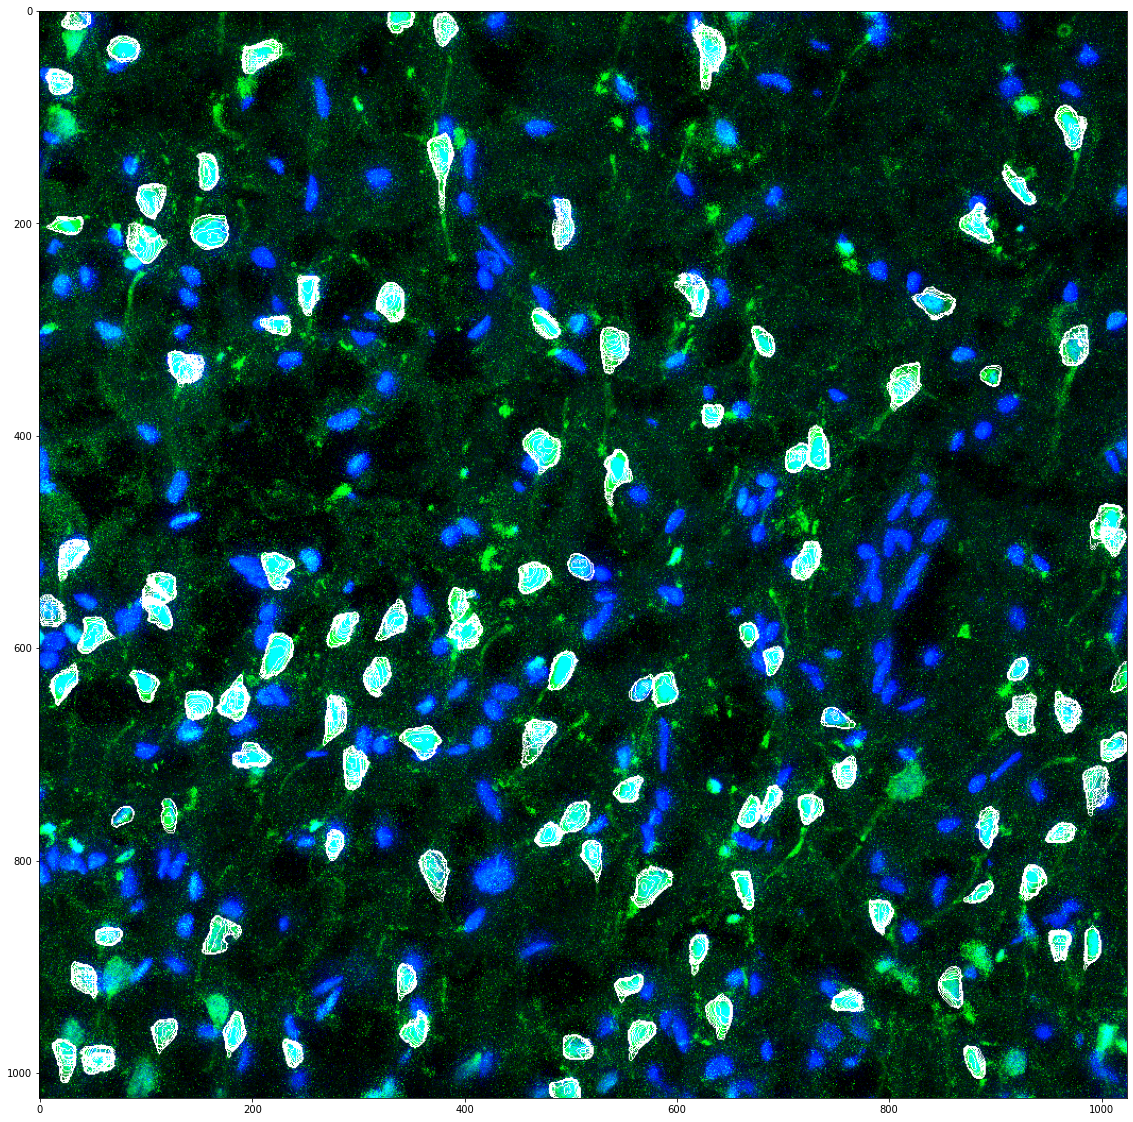

In [92]:
# show projection with filtering
plt.figure(figsize = (20,20))
mat2 = extract_channels([1,2], channels, mat[2:20])

show_maxproj_with_outlines(mat2, masks_copy[2:20])

100%|██████████| 18/18 [00:01<00:00, 16.29it/s]


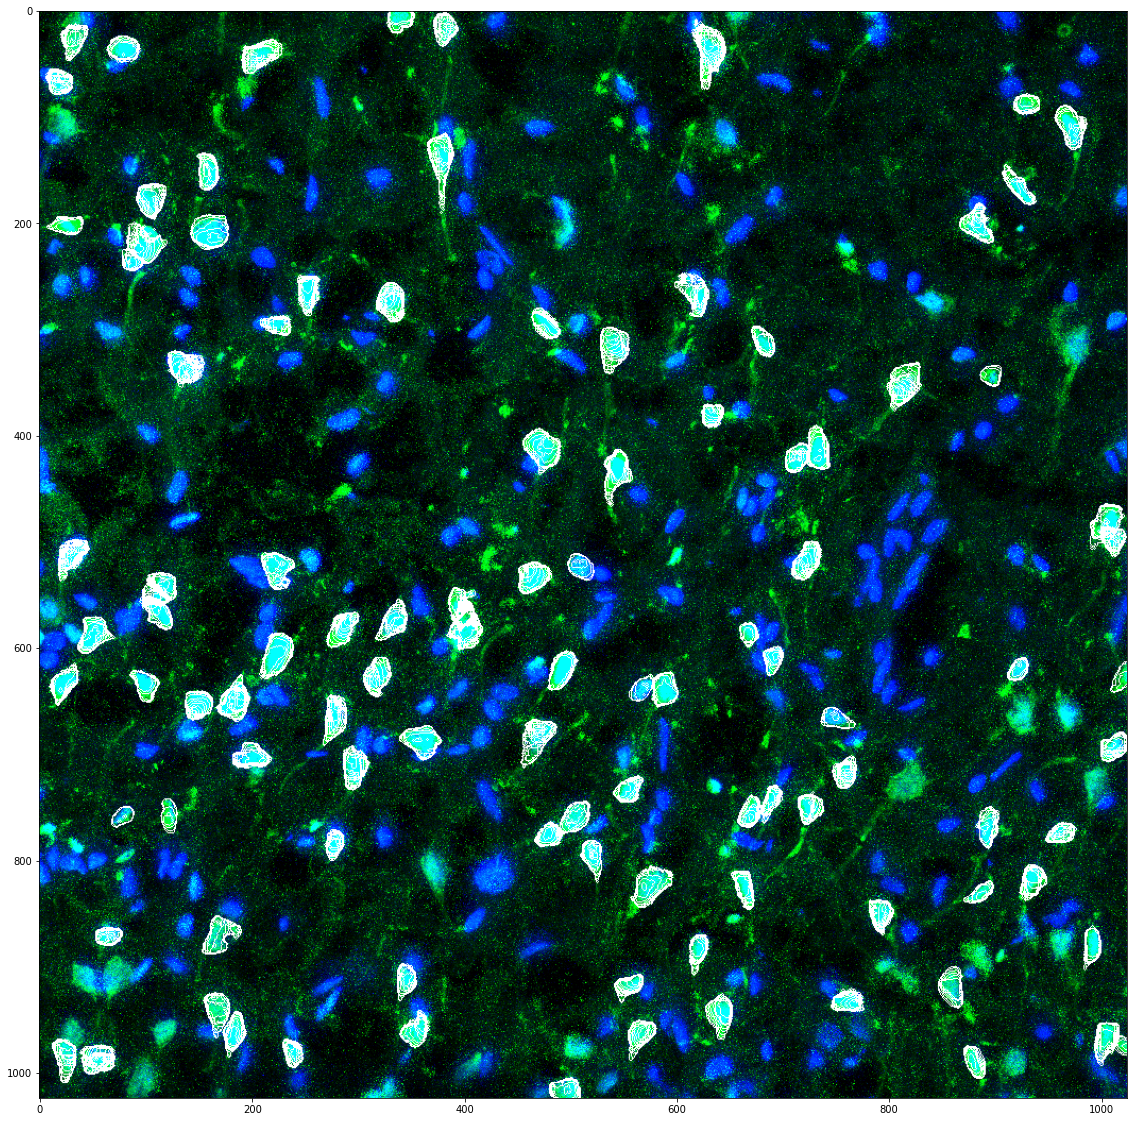

In [94]:
# show projection with filtering
plt.figure(figsize = (20,20))
mat2 = extract_channels([1,2], channels, mat[2:20])

show_maxproj_with_outlines(mat2, masks_copy[2:20])

100%|██████████| 15/15 [00:01<00:00, 12.55it/s]


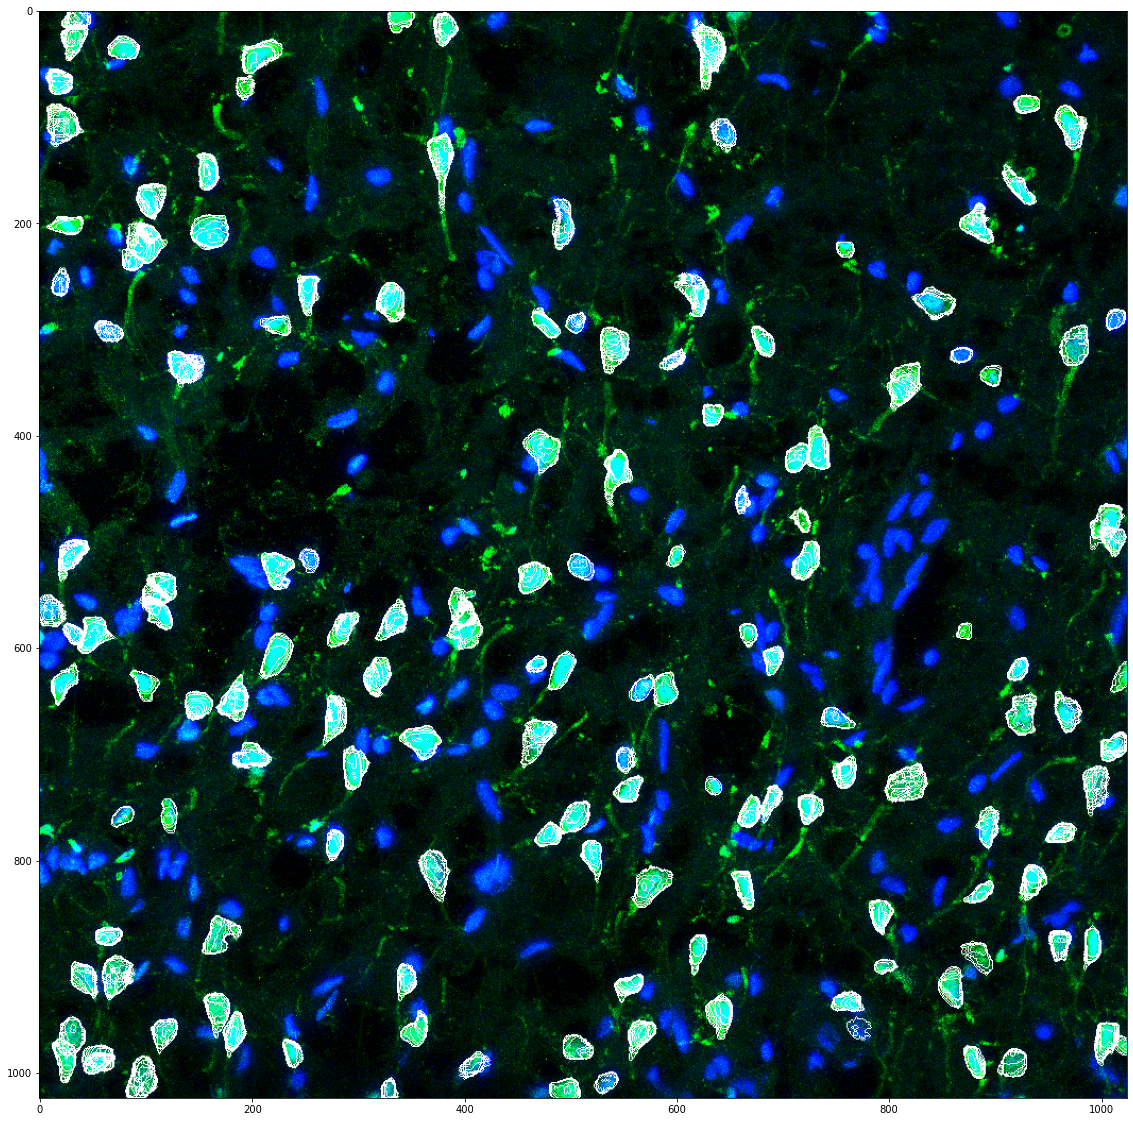

In [89]:
# show projection without filtering
plt.figure(figsize = (20,20))
mat2 = extract_channels([1,2], channels, mat[5:20])

show_maxproj_with_outlines(mat2, masks[5:20])

In [49]:
from main import get_czi_files

In [51]:
len(get_czi_files('./data/10252023_SREBP2_matchedcohort/'))

84

In [98]:
40*84

3360

In [97]:
len(np.unique(masks_copy))

110

In [ ]:
# will need to check how much the channel intensity for the channel we care about differs by image (ie if we need some kind of background subtraction)
# make pipeline runable on all images at once; so that Y_filtered gets concatenated - labeled by image - and then can look up the condition from the temp file

In [ ]:
# then have Colin repeat this blinded to results